In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('.'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.25e-3,0.25e-3,0.25e-3),
            matrix_dims = (256,256,128),
            baseline = (1500, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1500, rho=1000, sigma=0, scale=0.001, label=0)
wire = tissue.Tissue(name='wire', c=2000, rho=1400, sigma=20, scale=0.001, label=1)

pos = 0.016
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

wire_mask = np.zeros(test_phantom.matrix_dims)
wire_mask[128,128,:] = 1
wire_mask[128,192,:] = 1
wire_mask[192,128,:] = 1
wire_mask[192,192,:] = 1
wire_mask[160,160,:] = 1
test_phantom.add_tissue(wire, mask=wire_mask)

# for i in np.linspace(-0.016,0.016,128):
#     test_phantom.add_tissue_sphere((0,0,i), 1.5, wire)
#     test_phantom.add_tissue_sphere((pos,0,i), 1.5, wire)
#     test_phantom.add_tissue_sphere((0,pos,i), 1.5, wire)
#     test_phantom.add_tissue_sphere((pos,pos,i), 1.5, wire)
#     test_phantom.add_tissue_sphere((pos/2,pos/2,i), 1.5, wire)
    
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

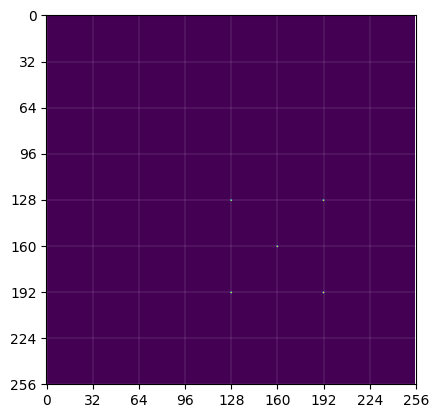

In [3]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])

plt.gca().set_xticks(np.linspace(0, test_phantom.matrix_dims[1],9))
plt.gca().set_yticks(np.linspace(0, test_phantom.matrix_dims[0],9))
plt.gca().grid(color='w', linestyle='-', linewidth=0.1)

In [4]:
num_transducers = 2
transducers = [transducer.Planewave(max_frequency=2e6,
                                    elements = 32, 
                                    width = 36e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = 0,
                                    ray_num = 1, 
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

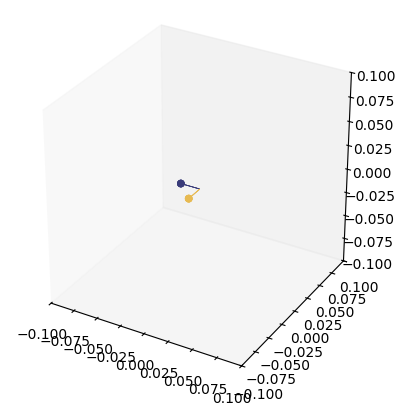

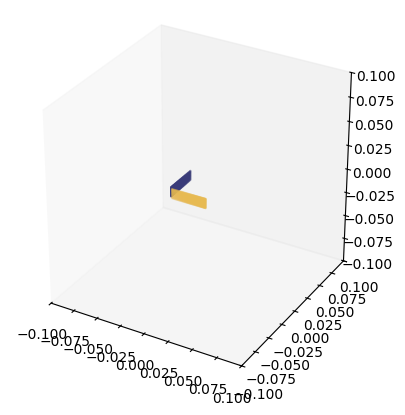

In [5]:
cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
cont_transducer_set.assign_pose(0, geometry.Transform([0,0,0], [-0.02,0,0]))
cont_transducer_set.assign_pose(1, geometry.Transform([np.pi/2,0,0], [0,-0.02,0]))


cont_transducer_set.plot_transducer_fovs(scale=0.1)
cont_transducer_set.plot_transducer_coords(scale=0.1)

In [6]:
extended_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='extended_aperture')
tar_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='transmit_as_receive')

In [7]:
simprops = simulation.SimProperties(
                grid_size   = (40e-3,40e-3,20e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,16,16),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [8]:
extended_experiment = experiment.Experiment(
                 simulation_path = 'extended_aperture',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = ['p_max']
                 )

tar_experiment = experiment.Experiment(
                 simulation_path = 'tar_aperture',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = tar_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = ['p_max']
                 )

extended_experiment.save()
tar_experiment.save()

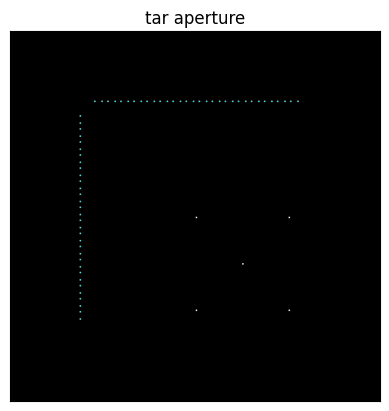

In [32]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2+1])
plt.gca().set_title('tar aperture')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('x_phantom.png', dpi=300)

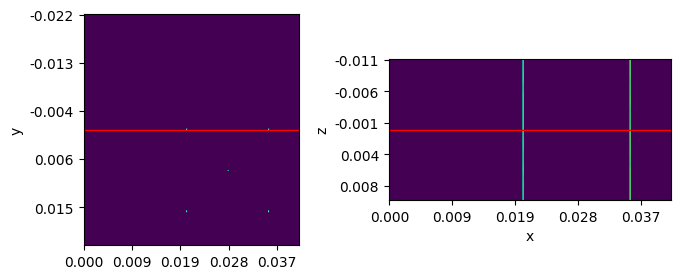

In [10]:
extended_experiment.plot_ray_path(0)

In [11]:
test_experiment = experiment.Experiment.load('tar_aperture')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

running with 2 workers



preparation for sim    0 completed in  8.32 seconds
preparation for sim    1 completed in  8.37 seconds
simulation             0 completed in 14.89 seconds
simulation             1 completed in 14.52 seconds
successfully joined 1 preparation processes and 1 run process


In [12]:
test_experiment = experiment.Experiment.load('extended_aperture')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

running with 2 workers



preparation for sim    0 completed in  8.29 seconds
preparation for sim    1 completed in  8.25 seconds
simulation             0 completed in 14.88 seconds
simulation             1 completed in 14.53 seconds
successfully joined 1 preparation processes and 1 run process


# Reconstruction

In [13]:
test_experiment = experiment.Experiment.load('tar_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


In [14]:
images1 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False)

Matrix Dims:  [256 256 128]
Voxel Dims:  [0.00025 0.00025 0.00025]


100%|██████████| 2/2 [00:00<00:00, 60349.70it/s]


In [15]:
image1 = np.sum(images1, axis=0)
image1t1 = np.sum(images1[:len(images1)//2], axis=0)
image1t2 = np.sum(images1[len(images1)//2:], axis=0)

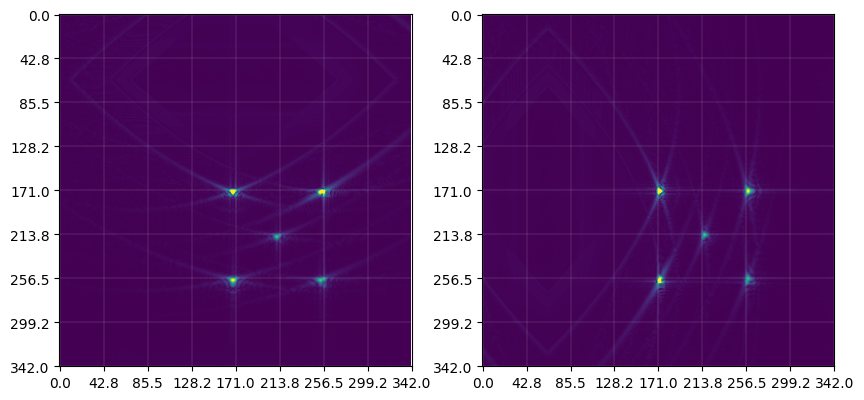

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image1t1, vmin=0, vmax=5e5)
ax[1].imshow(image1t2, vmin=0, vmax=5e5)

for a in ax:
    a.set_xticks(np.linspace(0, image1.shape[1],9))
    a.set_yticks(np.linspace(0, image1.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)


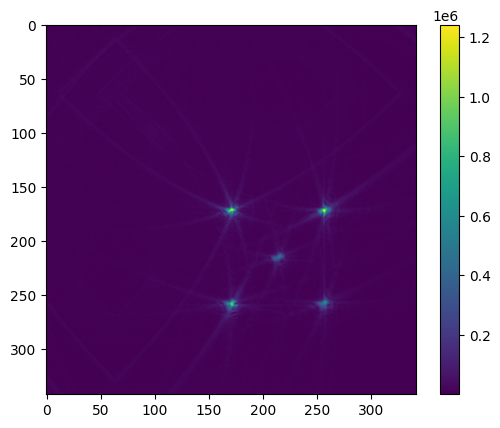

In [17]:
plt.imshow(image1[:,:,image1.shape[2]//2])
plt.colorbar()

In [18]:
test_experiment = experiment.Experiment.load('extended_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


In [19]:
images2 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False)

Matrix Dims:  [256 256 128]
Voxel Dims:  [0.00025 0.00025 0.00025]


100%|██████████| 2/2 [00:00<00:00, 67108.86it/s]


In [20]:
image2 = np.sum(images2, axis=0)
image2t1 = np.sum(images2[:len(images2)//2], axis=0)
image2t2 = np.sum(images2[len(images2)//2:], axis=0)

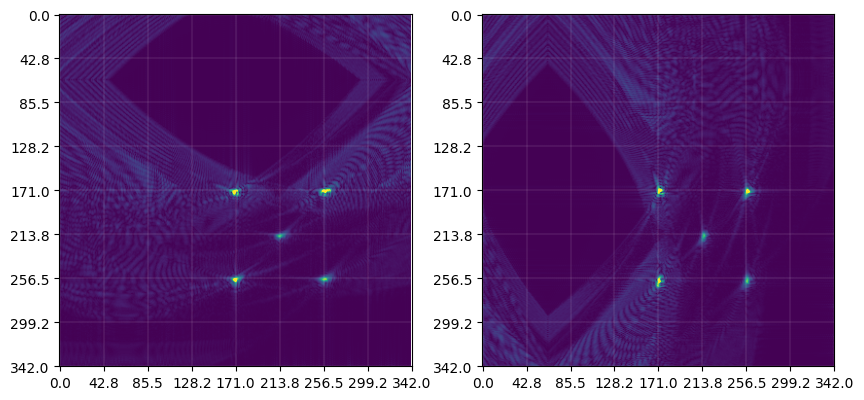

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image2t1, vmin=0, vmax=1e5)
ax[1].imshow(image2t2, vmin=0, vmax=1e5)

for a in ax:
    a.set_xticks(np.linspace(0, image2.shape[1],9))
    a.set_yticks(np.linspace(0, image2.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)


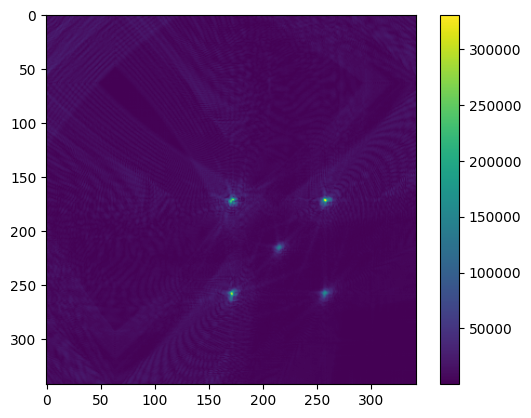

In [22]:
plt.imshow(image2[:,:,image2.shape[2]//2])
plt.colorbar()

In [ ]:
# pfield = utils.load_array('1mhz_pfield.npz')

In [ ]:
# plt.imshow(pfield)

In [ ]:
# test_experiment = experiment.Experiment.load('../experiment_files/tar_aperture')
# test_experiment.run(dry=True)
# test_experiment.add_results()
# test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [ ]:
images1_ap = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, combine=False, pressure_field=pfield)

In [ ]:
# plt.imshow(np.sum(images1_ap[:30][:,:,images1_ap[0].shape[2]//2], axis=0))
# # plt.imshow(images1_ap[0][1][:,:,images1_ap[0][1].shape[2]//2], alpha=0.5)
# plt.colorbar()

In [ ]:
image1_ap = np.sum(images1_ap, axis=0)
image1t1_ap = np.sum(images1_ap[:len(images1_ap)//3], axis=0)
image1t2_ap = np.sum(images1_ap[len(images1_ap)//3:2*len(images1_ap)//3], axis=0)
image1t3_ap = np.sum(images1_ap[2*len(images1_ap)//3:], axis=0)

In [ ]:
plt.imshow(image1_ap[:,:,image1_ap.shape[2]//2])
plt.colorbar()

In [ ]:
test_experiment = experiment.Experiment.load('../experiment_files/extended_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [ ]:
image2_ap = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, pressure_field=pfield)

In [ ]:
plt.imshow(image2_ap[:,:,image2_ap.shape[2]//2])
plt.colorbar()

In [ ]:
test_experiment = experiment.Experiment.load('../experiment_files/gap_experiment_ea')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [ ]:
image3_ap = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, pressure_field=pfield)

In [ ]:
plt.imshow(image3_ap[:,:,image3_ap.shape[2]//2])
plt.colorbar()

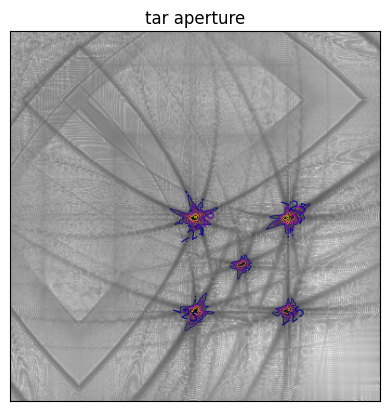

In [27]:
psf = 20 * np.log10(image1 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-25,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('tar aperture')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('x_tar_aperture.png', dpi=300)

In [ ]:
np.mean(image)

In [ ]:
psf = 20 * np.log10(image1_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = np.array([-30,-20,-15,-10,-5,0,])-70)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('tar aperture apodized')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_tar_aperture_apodized.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

psf = 20 * np.log10(image1t1 / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[0].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[0].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[0].clabel(CS, inline=True, fontsize=10)
ax[0].set_title('tar aperture t1')
ax[0].set_xticks([])
ax[0].set_yticks([])

psf = 20 * np.log10(image1t2 / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[1].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[1].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[1].clabel(CS, inline=True, fontsize=10)
ax[1].set_title('tar aperture t2')
ax[1].set_xticks([])
ax[1].set_yticks([])

psf = 20 * np.log10(image1t3 / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[2].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[2].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].set_title('tar aperture t3')
ax[2].set_xticks([])
ax[2].set_yticks([])



plt.savefig('two_spheres_tar_aperture_components.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

psf = 20 * np.log10(image1t1_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[0].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[0].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[0].clabel(CS, inline=True, fontsize=10)
ax[0].set_title('tar aperture apodized t1')
ax[0].set_xticks([])
ax[0].set_yticks([])

psf = 20 * np.log10(image1t2_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[1].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[1].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[1].clabel(CS, inline=True, fontsize=10)
ax[1].set_title('tar aperture apodized t2')
ax[1].set_xticks([])
ax[1].set_yticks([])

psf = 20 * np.log10(image1t3_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[2].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[2].contour(image, cmap='plasma', linewidths=0.5, levels = np.array([-30,-20,-15,-10,-5,0,]))
ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].set_title('tar aperture apodized t3')
ax[2].set_xticks([])
ax[2].set_yticks([])



plt.savefig('two_spheres_tar_aperture_apodized_components.png', dpi=300)

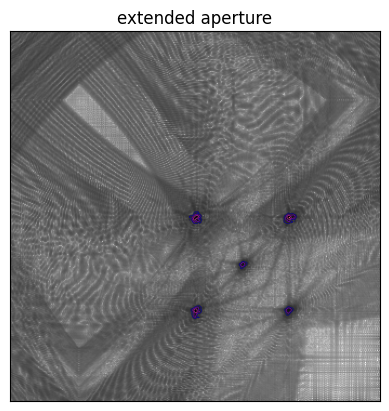

In [31]:
psf = 20 * np.log10(image2 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-25,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('extended aperture')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('x_extended_aperture.png', dpi=300)

In [ ]:
psf = 20 * np.log10(image2_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('extended aperture apodized')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_extended_aperture_apodized.png', dpi=300)

In [ ]:
psf = 20 * np.log10(image3 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('gap extended aperture')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_gap_extended_aperture.png', dpi=300)

In [ ]:
psf = 20 * np.log10(image3_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('gap extended aperture apodized')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_gap_extended_aperture_apodized.png', dpi=300)